In [ ]:
# Following script combines the annotation data with the time series data
path = r'C:\Users\Grover\Documents\GitHub\EZLabel\true_annotations'
dict_path = r'Z:\mfk\basty-projects\tmp_results\predictions\ProboscisPumping\bouts_dict.pkl'

import pandas as pd
import os
import glob


def process_row(row, dictionary, N):
    df_dict = dictionary[row['name']]
    df_dict_filtered = df_dict.drop(['start_index', 'stop_index', 'region'], axis=1)

    trial_id = int(row['trial_id'])
    peak_index = row['peak_index']

    # New dictionary to store sliced data with column names
    sliced_data_dict = {}

    for col in df_dict_filtered.columns:
        if peak_index-N >= 0 and peak_index+N <= len(df_dict_filtered.loc[trial_id, col]):
            start = max(0, peak_index - N)
            end = min(len(df_dict_filtered.loc[trial_id, col]), peak_index + N)
            sliced_data_dict[col] = df_dict_filtered.loc[trial_id, col][start:end]

    return sliced_data_dict


In [ ]:

pkl_files = glob.glob(os.path.join(path, '*.pkl'))
ts_dict = pd.read_pickle(dict_path)

df_list = []  # A list to store each DataFrame


for file in pkl_files:
    data = pd.read_pickle(file)
    df = pd.DataFrame(data)
    df['name'] = os.path.splitext(os.path.basename(file))[0]
    df_list.append(df)  # Append the DataFrame to the list

# Concatenate all the DataFrames in the list into a single DataFrame
annotations = pd.concat(df_list, ignore_index=True)

# Rename the columns to make it more intuitive
annotations.rename(columns = {'index':'peak_index','column':'trial_id'},inplace=True)

In [ ]:
# Create an empty DataFrame to store all the processed rows
processed_data_df = pd.DataFrame()

# Initialize a counter for slice
slice_counter = 0

# Loop through each row in annotations
for i, row in annotations.iterrows():
    processed_row = process_row(row, ts_dict, 30)

    # Create a DataFrame for this row
    row_df = pd.DataFrame(processed_row)

    # Add 'slice_id' to the DataFrame
    row_df['slice_id'] = slice_counter

    # Set a multi-index using 'name', 'slice_id' and the existing index of row_df
    row_df.index = pd.MultiIndex.from_tuples([(row['name'], slice_counter, i) for i in row_df.index],
                                             names=['name', 'slice_id', 'time'])

    # Append it to processed_data_df
    processed_data_df = pd.concat([processed_data_df, row_df])

    # Increment the slice_counter
    slice_counter += 1


In [ ]:
import numpy as np
# Create a dictionary where key is (name, slice_id) and value is the sub-DataFrame
df_dict = dict(tuple(processed_data_df.groupby(level=['name', 'slice_id'])))

# Initialize an empty list to store each 2D array
array_list = []

# Loop over the dictionary
for key in df_dict:
    # Convert each DataFrame to a 2D numpy array and append to list
    array_list.append(df_dict[key].values)

# Convert list of arrays to a 3D numpy array
np_array = np.stack(array_list)


In [ ]:
output_path = r'C:\Users\Grover\Documents\GitHub\EZLabel'

processed_data_df.to_pickle(os.path.join(output_path,'false_peak_annotations.pkl'))

In [ ]:
np.save(os.path.join(output_path,'false_peak_annotations.npy'),np_array)

In [ ]:
output_path = r'C:\Users\Grover\Documents\GitHub\EZLabel\true_annotations\output'
annotations.to_pickle(os.path.join(output_path,'true_annotations.pkl'))

In [1]:
import pandas as pd
import os

# Load annotations and experimental info: 
path = r'C:\Users\Grover\Documents\GitHub\EZLabel\true_annotations'
annotations = pd.read_pickle(os.path.join(path,'output','true_annotations.pkl'))
expt_info_df_path = r'Z:\mfk\basty-projects\expt_info_df.pkl'
expt_info_df = pd.read_pickle(expt_info_df_path)

# Fetch all .mp4 files from the directory
directory = r'Y:\DeepSleepPaperData\Annotated\PredictedVideos\Pumping'
file_names = [f for f in os.listdir(directory) if f.endswith('.mp4')]

# Process each filename
data = []

for file in file_names:
    parts = file.split("_")

    index_position = parts.index('index')
    name = "_".join(parts[:index_position])
    trial_id = int(parts[index_position + 1])
    start = int(parts[parts.index('start') + 1])

    data.append([name, trial_id, start])

# Construct the DataFrame
df = pd.DataFrame(data, columns=["name", "trial_id", "start"])

annotations['trial_id'] = annotations['trial_id'].astype('int64')
df['trial_id'] = df['trial_id'].astype('int64')
merged_df = annotations.merge(df[['name', 'trial_id', 'start']], on=['name', 'trial_id'], how='left')

merged_df['pump_pos'] = merged_df['peak_index'] + merged_df['start']

In [2]:
merged_df

,peak_index,value,trial_id,name,start,pump_pos
0,534,1014.361120,0,Fly05182022_5d,2349,2883
1,694,1017.733769,0,Fly05182022_5d,2349,3043
2,903,1027.228163,0,Fly05182022_5d,2349,3252
3,1207,1021.721591,0,Fly05182022_5d,2349,3556
4,1623,1023.545935,0,Fly05182022_5d,2349,3972
...,...,...,...,...,...,...
8486,835,387.119720,22,Fly08032022_6d_SD_B,625280,626115
8487,905,386.726096,22,Fly08032022_6d_SD_B,625280,626185
8488,966,389.234434,22,Fly08032022_6d_SD_B,625280,626246
8489,1041,504.997931,22,Fly08032022_6d_SD_B,625280,626321


In [ ]:
merged_df.to_csv(os.path.join(path,"all_true_annotations.csv"))

In [3]:
name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))

df = merged_df

# Split df into two based on SD value
df_sd_true = df[df['name'].map(name_to_sd)]
df_sd_false = df[~df['name'].map(name_to_sd)]

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# Helper function to plot given a subset of df
def plot_data(subset_df, color, sd, sex):
    sns.set(style="ticks")
    plt.clf()
    fig, ax = plt.subplots(figsize=(15, len(subset_df['name'].unique()) / 4))

    color='#FF7F0E'
    unique_names = subset_df['name'].unique()

    for idx, name in enumerate(unique_names):
        sub_subset_df = subset_df[subset_df['name'] == name]
        for _, row in sub_subset_df.iterrows():
            pump_pos = row['pump_pos']
            ax.barh(idx, 60, left=pump_pos - 30, color=color, edgecolor='none')

    fly_labels = [f"Fly{i+1}" for i in range(len(unique_names))]
    ax.set_yticks(range(len(unique_names)))
    ax.set_yticklabels(fly_labels)

    ZT_ticks, ZT_ticklabels = generate_tick_data(30, sd=sd)
    ax.set_xticks(ZT_ticks)
    ax.set_xticklabels(ZT_ticklabels)

    # Set x-axis limits to the beginning and end of the x-ticks
    ax.set_xlim(ZT_ticks[0], ZT_ticks[-1])

    title = f'SD_True_{sex}' if sd else f'SD_False_{sex}'
    ax.set_title(title)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f'Pump_Positions_{title}.pdf')
    plt.show()


# Function to plot data for SD = True
def plot_sd_true():
    df_sd_true = df[df['name'].map(name_to_sd)]
    plot_data(df_sd_true, '#377eb8', sd=True)


# Function to plot data for SD = False
def plot_sd_false():
    df_sd_false = df[~df['name'].map(name_to_sd)]
    plot_data(df_sd_false, '#d62728', sd=False)
    
def plot_sub_data(df, expt_info_df, sd, sex,plot_it):

    # Create mappings from expt_info_df
    name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
    name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))
    
    # Filter based on provided sd and sex values
    sub_df = df[(df['name'].map(name_to_sd) == sd) & (df['name'].map(name_to_sex) == sex)]
    
    if plot_it:
        plot_data(sub_df, '#d62728', sd=sd,sex=sex)
        
    plt.show()
    
    return sub_df,sd,sex
    
def generate_tick_data(FPS=30, sd=False):

    if sd == False:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 16 + 1, step=FPS * 60 * 60 * 2
        )
        ZT_ticks = xticks
        ZT_ticklabels = [
            "ZT" + str((tick + 10) % 24) for tick in range(0, len(xticks) * 2, 2)
        ]
    else:
        xticks = np.arange(
            start=0, stop=FPS * 60 * 60 * 6 + 1, step=FPS * 60 * 60 * 1
        )
        ZT_ticks = xticks
        ZT_ticklabels = [
            "ZT" + str(tick) for tick in range(0, len(xticks) * 1, 1)
        ]

    return ZT_ticks, ZT_ticklabels


In [42]:
# Load manual annotations
new_sd_flies = pd.read_csv(r'Y:\DeepSleepPaperData\ManuallyAnnotatedSD\ProbPumping_data.csv')

In [43]:
new_sd_flies['pump_pos'] = ((new_sd_flies['start_idx'] + new_sd_flies['stop_idx']) / 2).astype(int)
new_sd_flies = new_sd_flies.rename(columns = {'region':'name'})
sub_df,_,_ = plot_sub_data(df,expt_info_df,sd=True,sex='F',plot_it=False)

# Concat the new data with the old data
sub_df_new = pd.concat([sub_df, new_sd_flies], ignore_index=True)

In [44]:

# Step 1: Filter the DataFrame where 'pump_pos' < 3600
filtered_df = sub_df_new[sub_df_new['pump_pos'] < 30*60*60*2]

# Step 2: Count the number of 'pump_pos' entries for each unique 'name'
pump_pos_counts_sd = filtered_df.groupby('name')['pump_pos'].count()

In [45]:
sub_df,_,_ = plot_sub_data(df,expt_info_df,sd=False,sex='F',plot_it=False)

# Step 1: Filter the DataFrame where 'pump_pos' < 30*60*60*14
filtered_df = sub_df[sub_df['pump_pos'] > 30*60*60*14]

# Step 2: Count the number of 'pump_pos' entries for each unique 'name'
pump_pos_counts = filtered_df.groupby('name')['pump_pos'].count()

# Step 3: Get all unique names from sub_df to ensure no names are missing in the final count
all_names = sub_df['name'].unique()

# Step 4: Reindex the counts to include all unique names, filling missing entries with 0
pump_pos_counts_wt = pump_pos_counts.reindex(all_names, fill_value=0)


In [46]:

# Convert the Series to a DataFrame
pump_pos_counts_wt_df = pump_pos_counts_wt.to_frame(name='Count')

# Add a new column 'Source' with the value 'WT' for all entries
pump_pos_counts_wt_df['Source'] = 'WT'

# Repeat the same steps for the SD data
pump_pos_counts_sd_df = pump_pos_counts_sd.to_frame(name='Count')
pump_pos_counts_sd_df['Source'] = 'SD'

# Concatenate the two DataFrames
pump_pos_counts_df = pd.concat([pump_pos_counts_wt_df, pump_pos_counts_sd_df])

In [49]:
# Save as a CSV file
pump_pos_counts_df.to_csv('pump_pos_counts_w_new_sd.csv')

<Figure size 640x480 with 0 Axes>

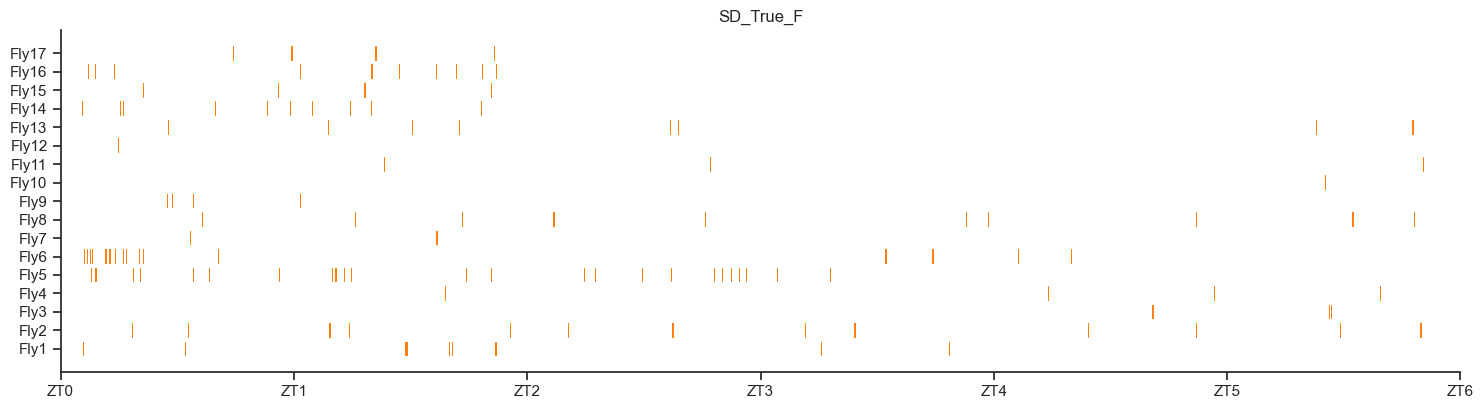

In [22]:
plot_data(sub_df_new, '#d62728', sd=True,sex='F')

<Figure size 640x480 with 0 Axes>

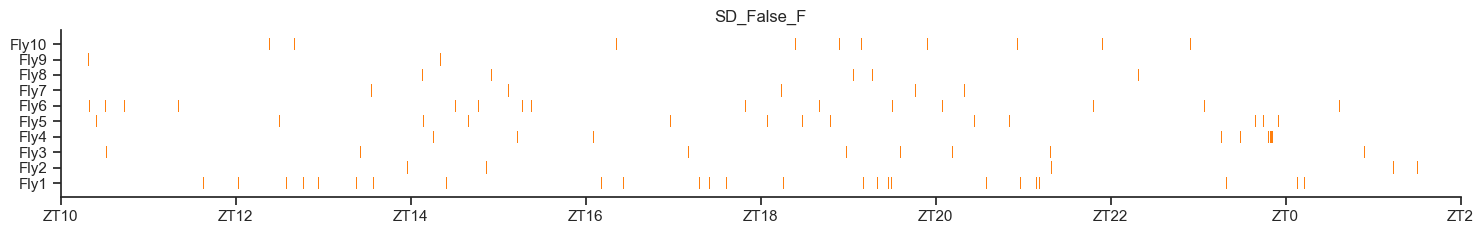

<Figure size 640x480 with 0 Axes>

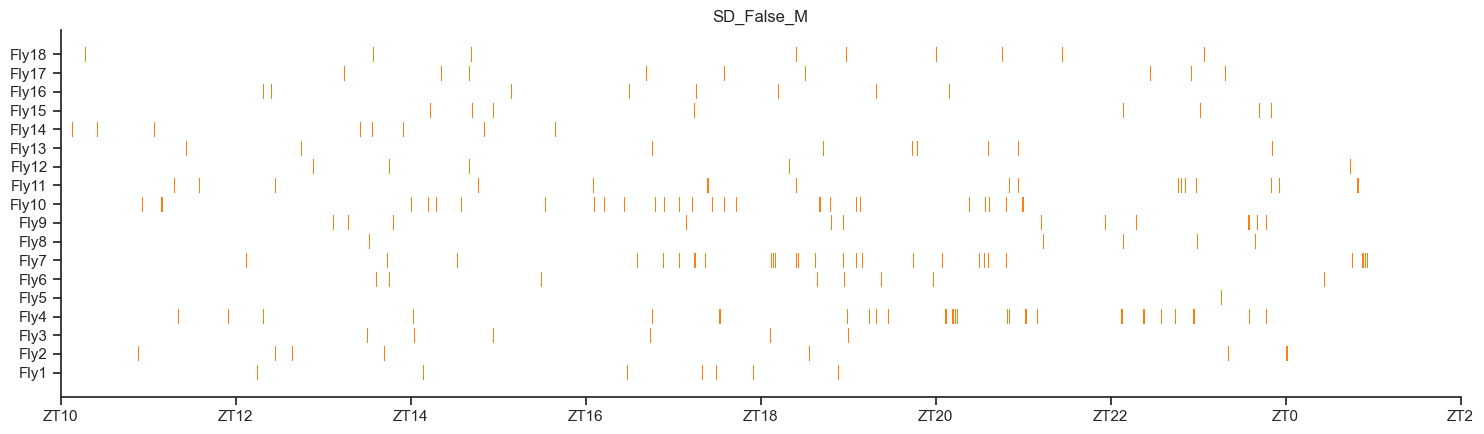

<Figure size 640x480 with 0 Axes>

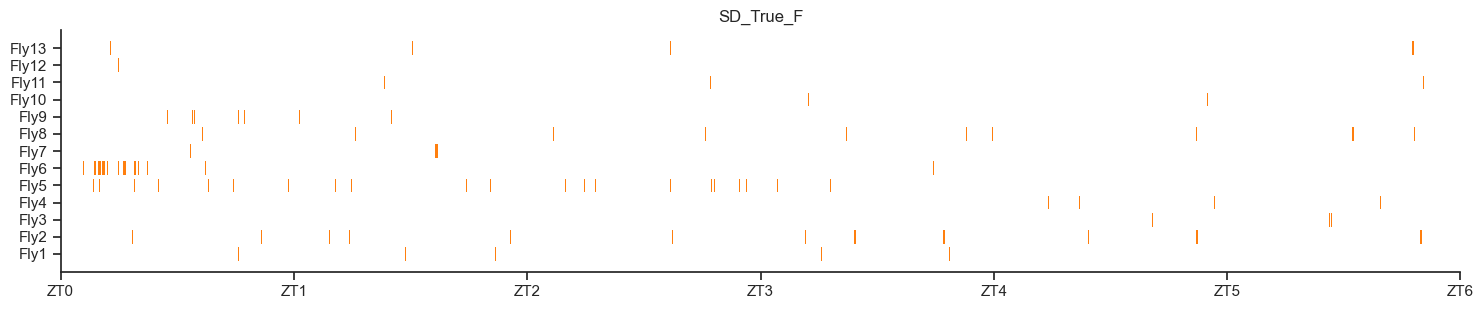

<Figure size 640x480 with 0 Axes>

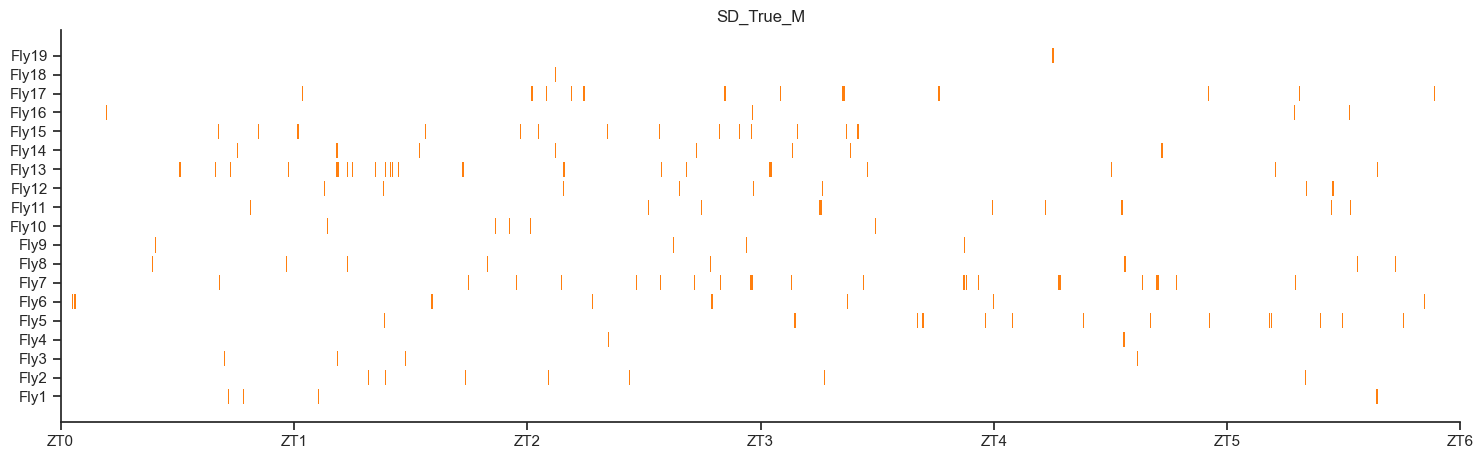

(      peak_index       value  trial_id                 name   start  pump_pos
 2296         610  614.317969         0  Fly06232022_5d_A_SD   76843     77453
 2297         776  635.888765         0  Fly06232022_5d_A_SD   76843     77619
 2298         859  644.573873         0  Fly06232022_5d_A_SD   76843     77702
 2299         924  645.045620         0  Fly06232022_5d_A_SD   76843     77767
 2300         987  644.763390         0  Fly06232022_5d_A_SD   76843     77830
 ...          ...         ...       ...                  ...     ...       ...
 7838        1156  690.553196        43  Fly07282022_6d_SD_B  458357    459513
 7839        1230  706.097488        43  Fly07282022_6d_SD_B  458357    459587
 7840        1317  690.102103        43  Fly07282022_6d_SD_B  458357    459674
 7841         544  649.298785        44  Fly07282022_6d_SD_B  599912    600456
 7842         608  636.337985        44  Fly07282022_6d_SD_B  599912    600520
 
 [1472 rows x 6 columns],
 True,
 'M')

In [11]:
plot_sub_data(df,expt_info_df,sd=False,sex='F',plot_it=True)
plot_sub_data(df,expt_info_df,sd=False,sex='M',plot_it=True)
plot_sub_data(df,expt_info_df,sd=True,sex='F',plot_it=True)
plot_sub_data(df,expt_info_df,sd=True,sex='M',plot_it=True)

In [32]:
import pandas as pd
sns.set_style('ticks')
def plot_bin_data(sub_df,sd,sex,plot_it=False):
        # Create mappings from expt_info_df
    name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
    name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))
    
    # Filter based on provided sd and sex values
    sub_df = df[(df['name'].map(name_to_sd) == sd) & (df['name'].map(name_to_sex) == sex)]
        
    plt.clf()
    
    plot_Df = sub_df
    # Convert pump_pos to minutes
    plot_Df['pump_pos_minutes'] = plot_Df['pump_pos'] / (30 * 60)
    
    # Define bin edges for 60-minute intervals
    max_minutes = plot_Df['pump_pos_minutes'].max()
    bins = list(range(0, int(max_minutes) + 61, 60))
    
    # For each unique 'name', bin the data and count values in each bin
    binned_data = {}
    for name, group in plot_Df.groupby('name'):
        binned_data[name] = pd.cut(group['pump_pos_minutes'], bins=bins).value_counts()
    
    # Convert the binned_data dictionary to a DataFrame
    binned_df = pd.DataFrame(binned_data).T
    binned_df = binned_df.fillna(0).astype(int)  # Replace NaN values with zeros and convert to integer type
    
    # Calculate the average for each bin across all "names"
    melted_df = binned_df.melt(var_name='Time Bin', value_name='Average Count')
    
    import seaborn as sns

    if plot_it==True:
        # Create the boxplot using seaborn
        plt.figure(figsize=(12, 6))
        sns.barplot(data=melted_df, x='Time Bin', y='Average Count', color='skyblue', errorbar='se')
        # Adjusted box width and color
        
        # Calculate the median values for each time bin and plot them
        means = melted_df.groupby('Time Bin')['Average Count'].mean()
        plt.plot(range(len(means)), means, color='black', linestyle='-', marker='o')
        
        # Set the x-tick labels to your ZT values
        if ~sd:
            ZT_labels = [f"ZT{((i + 10) % 24)}" for i in range(len(means))]
            plt.xticks(ticks=range(len(ZT_labels)), labels=ZT_labels, rotation=45)
        else:
            ZT_labels = [f"ZT{((i))}" for i in range(len(means))]
            plt.xticks(ticks=range(len(ZT_labels)), labels=ZT_labels, rotation=45)
                
    
        # Set y-label
        plt.ylabel("Pump per Hour")
    
        
        title = f"Avg_Binned_SD_{sd}_sex{sex}"
        plt.title(title)
        plt.tight_layout()
        sns.despine()
        plt.savefig(f'{title}_barplot.pdf')
        plt.show()
        
    else: 
        return binned_df

C:\Users\Grover\AppData\Local\Temp\ipykernel_8668\2416642503.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_Df['pump_pos_minutes'] = plot_Df['pump_pos'] / (30 * 60)


<Figure size 640x480 with 0 Axes>

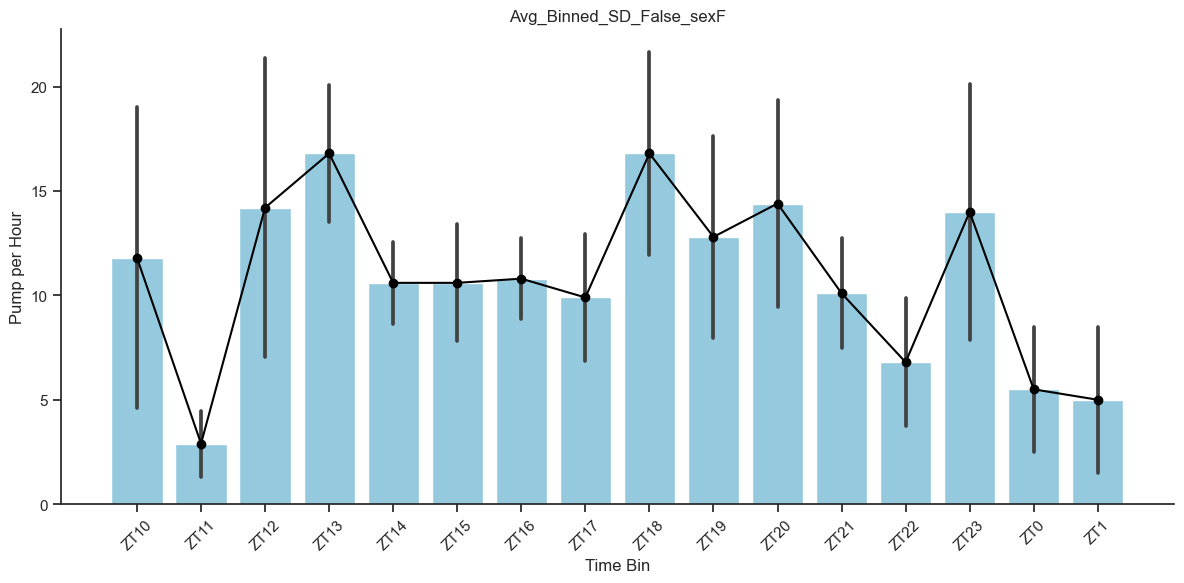

C:\Users\Grover\AppData\Local\Temp\ipykernel_8668\2416642503.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_Df['pump_pos_minutes'] = plot_Df['pump_pos'] / (30 * 60)


<Figure size 640x480 with 0 Axes>

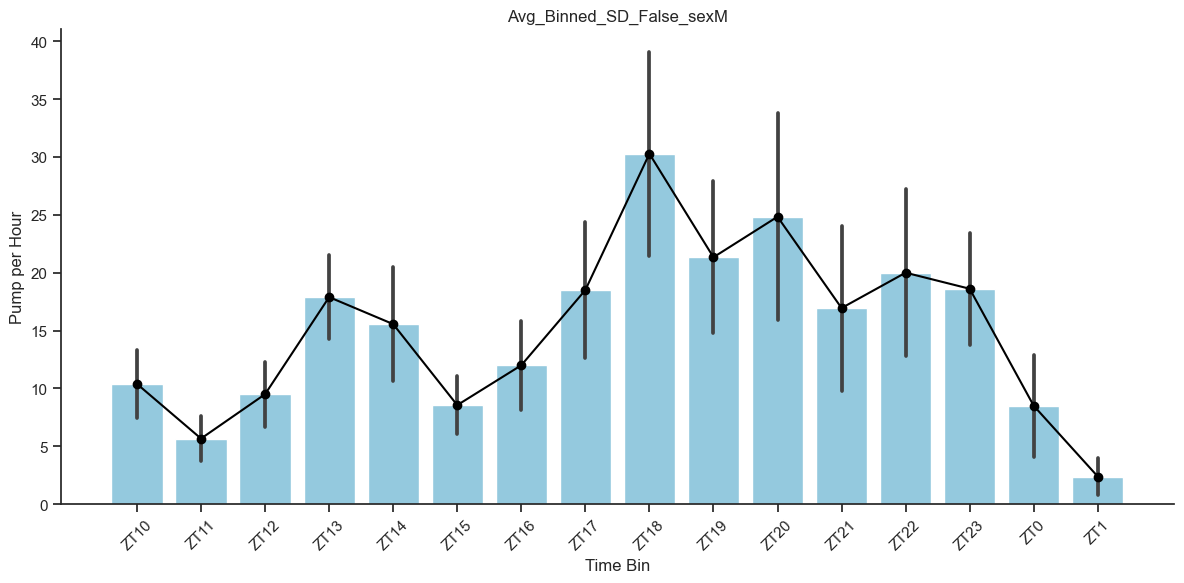

In [33]:
binned_df = plot_bin_data(df,sd=False,sex = 'F',plot_it=True)
#binned_df.to_csv(F'binned_data_sd_false_sex_f.csv')

binned_df = plot_bin_data(df,sd=False,sex = 'M',plot_it=True)
#binned_df.to_csv('binned_data_sd_false_sex_m.csv')

#binned_df = plot_bin_data(df,sd=True,sex = 'F',plot_it=False)
#binned_df.to_csv('binned_data_sd_True_sex_f.csv')

#binned_df = plot_bin_data(df,sd=True,sex = 'M',plot_it=False)
#binned_df.to_csv('binned_data_sd_True_sex_m.csv')


In [12]:
sub,sd,sex = plot_sub_data(df,expt_info_df,sd=True,sex='M',plot_it=False)

In [13]:
# create a sub array with pump_pos and name
sub = sub[['pump_pos','name']]

if sd:
    max_hour = 6
else:
    max_hour = 16

# Create bins for each 120 minute interval
bins = list(range(0, 30*60 * 60 * max_hour + 1, 30*60 * 60 * 2))

# Bin the data
sub['binned'] = pd.cut(sub['pump_pos'], bins=bins)

# Averagethe data for each unique 'name' and 'binned' combination
sub = sub.groupby(['name', 'binned']).size().reset_index(name='counts')

if sd:
    #Grab the smallest bin for each name
    sub = sub.groupby('name').first().reset_index()
else:
    #Grab the largest bin for each name
    sub = sub.groupby('name').last().reset_index()


In [34]:
# Calculate Bouts
def calculate_bouts(target_df, target_threshold):
    # Re-initialize the 'bouts' column with default value 0
    target_df['bouts'] = 0
    
    # Loop through each unique 'name' to identify bouts based on 'pump_pos'
    for name in target_df['name'].unique():
        # Filter the DataFrame for the current 'name'
        subset_df = target_df[target_df['name'] == name].sort_values(by='pump_pos')
        
        # Calculate the differences between consecutive 'pump_pos'
        pump_diffs = subset_df['pump_pos'].diff().fillna(0)
        
        # Initialize a variable to keep track of the current bout number
        current_bout = 0
        
        # Initialize a variable to keep track of the last pump position in the current bout
        last_pump_in_bout = -1
        
        # Loop through the DataFrame to identify bouts
        for idx, pump_diff in pump_diffs.items():
            if pump_diff > target_threshold:
                # If the difference between the current and last pump position is greater than the threshold, start a new bout
                current_bout += 1
                last_pump_in_bout = target_df.loc[idx, 'pump_pos']
            elif last_pump_in_bout != -1 and (target_df.loc[idx, 'pump_pos'] - last_pump_in_bout) > target_threshold:
                # If the difference between the current pump position and the last pump position in the current bout is greater than the threshold, start a new bout
                current_bout += 1
                last_pump_in_bout = target_df.loc[idx, 'pump_pos']
            else:
                # Otherwise, the current pump position is part of the current bout
                last_pump_in_bout = target_df.loc[idx, 'pump_pos']
            
            # Label the current bout number in the 'bouts' column
            target_df.loc[idx, 'bouts'] = current_bout
            
    return target_df



In [54]:
# Update the threshold for identifying bouts to 210
threshold = 330
bout_df = merged_df.copy()

In [79]:
merged_df

,peak_index,value,trial_id,name,start,pump_pos,pump_pos_minutes
0,534,1014.361120,0,Fly05182022_5d,2349,2883,1.601667
1,694,1017.733769,0,Fly05182022_5d,2349,3043,1.690556
2,903,1027.228163,0,Fly05182022_5d,2349,3252,1.806667
3,1207,1021.721591,0,Fly05182022_5d,2349,3556,1.975556
4,1623,1023.545935,0,Fly05182022_5d,2349,3972,2.206667
...,...,...,...,...,...,...,...
8486,835,387.119720,22,Fly08032022_6d_SD_B,625280,626115,347.841667
8487,905,386.726096,22,Fly08032022_6d_SD_B,625280,626185,347.880556
8488,966,389.234434,22,Fly08032022_6d_SD_B,625280,626246,347.914444
8489,1041,504.997931,22,Fly08032022_6d_SD_B,625280,626321,347.956111


In [55]:
df = calculate_bouts(bout_df,threshold)

In [56]:
sorted_df = df.sort_values(by=['name', 'pump_pos'])

In [10]:
import matplotlib.pyplot as plt
def plot_bout_data(subset_df, color, sd=False, sex="unknown"):
    fig, ax = plt.subplots(figsize=(15, len(subset_df['name'].unique()) / 4))
    unique_names = subset_df['name'].unique()

    for idx, name in enumerate(unique_names):
        sub_subset_df = subset_df[subset_df['name'] == name]
        
        for bout, bout_df in sub_subset_df.groupby('bouts'):
            min_pump_pos = bout_df['pump_pos'].min()
            ax.barh(idx, 60, left=min_pump_pos - 30, color=color, edgecolor='none')

    fly_labels = [f"Fly{i+1}" for i in range(len(unique_names))]
    ax.set_yticks(range(len(unique_names)))
    ax.set_yticklabels(fly_labels)

    ZT_ticks, ZT_ticklabels = generate_tick_data(30, sd=sd)
    ax.set_xticks(ZT_ticks)
    ax.set_xticklabels(ZT_ticklabels)

    # Set x-axis limits to the beginning and end of the x-ticks
    ax.set_xlim(ZT_ticks[0], ZT_ticks[-1])

    title = f'SD_True_{sex}' if sd else f'SD_False_{sex}'
    ax.set_title(title)

    plt.tight_layout()
    plt.savefig(f'Pump_Positions_bouts_{title}.pdf')
    plt.show()

In [11]:
def plot_bout_sub_data(df, expt_info_df, sd, sex,plot_it):
    # Create mappings from expt_info_df
    name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
    name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))
    
    # Filter based on provided sd and sex values
    sub_df = df[(df['name'].map(name_to_sd) == sd) & (df['name'].map(name_to_sex) == sex)]
    
    if plot_it:
        plot_bout_data(sub_df, '#d62728', sd=sd,sex=sex)
    

In [ ]:
rep_trace_path = r'Z:\mfk\basty-projects\bouts_to_csv\Fly06272022_5d_A.csv'
rep_trace = pd.read_csv(rep_trace_path)
# Define your start, stop, and step values for the ticks
start = 500
stop = 5600
step = 10*30

# Generate the tick positions and labels
tick_positions = np.arange(start, stop, step)
tick_labels = np.arange(0, len(tick_positions)*10, 10)

# Plot the data
plt.plot(rep_trace['65'][start:stop])
plt.ylabel('Euclidian Distance (px)')
plt.xlabel('Time (s)')
# Set the x-axis ticks and labels
plt.xticks(tick_positions, tick_labels)
plt.savefig('example_trace_49_pumps_trial_65_fly06272022_5d_A.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
plot_bout_sub_data(sorted_df,expt_info_df,True,'M',True)

In [39]:
print(sorted_df.head())

    peak_index        value  trial_id            name  start  pump_pos  \
0          534  1014.361120         0  Fly05182022_5d   2349      2883   
1          694  1017.733769         0  Fly05182022_5d   2349      3043   
2          903  1027.228163         0  Fly05182022_5d   2349      3252   
3         1207  1021.721591         0  Fly05182022_5d   2349      3556   
84        1439   916.637105         0  Fly05182022_5d   2349      3788   

    pump_pos_minutes  bouts  
0           1.601667      0  
1           1.690556      0  
2           1.806667      0  
3           1.975556      1  
84          2.104444      1  


In [51]:
grouped_one = sorted_df.groupby(['name','bouts']).size().reset_index(name = 'counts')
grouped_two = sorted_df.groupby(['name','start']).size().reset_index(name = 'counts')


In [65]:
slim_df = sorted_df.copy()

# Remove value trial_id,peak_index, and pump_pos_minutes from the dataset
slim_df = slim_df.drop(['value','trial_id','peak_index','pump_pos_minutes'],axis=1)

In [74]:
# Group by 'name', 'pump_pos', and 'bouts', then aggregate with min for 'start' and count for 'index'
fin_df = slim_df.groupby(['name', 'bouts']).agg(first_instance=('pump_pos', 'min'), count=('bouts', 'count')).reset_index()

In [80]:
fin_df

,name,bouts,first_instance,count
0,Fly05182022_5d,0,2883,6
1,Fly05182022_5d,1,17344,4
2,Fly05182022_5d,2,40839,2
3,Fly05182022_5d,3,42792,6
4,Fly05182022_5d,4,44462,1
...,...,...,...,...
1967,Fly08032022_6d_SD_B,27,384691,3
1968,Fly08032022_6d_SD_B,28,531935,3
1969,Fly08032022_6d_SD_B,29,581337,3
1970,Fly08032022_6d_SD_B,30,616915,3


In [78]:
# Save fin_df to a csv file
fin_df.to_csv('bout_data.csv')

In [41]:
# Possible values for sd and sex
sd_values = [False, True]
sex_values = ['M', 'F']
name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))

grouped_dict = {}

# Loop through each combination of sd and sex to filter and store the DataFrame
for sd in sd_values:
    for sex in sex_values:
        sub_df = grouped[(grouped['name'].map(name_to_sd) == sd) & (grouped['name'].map(name_to_sex) == sex)]
        key = f"sd_{sd}_sex_{sex}"
        grouped_dict[key] = sub_df

In [15]:
import matplotlib.pyplot as plt
import numpy as np
def plot_single_histogram_with_average(grouped_df, title):
    plt.figure(figsize=(12, 8))
    
    all_hist_data = []
    
    # Determine common bin edges based on the entire data range
    data_min = grouped_df['counts'].min()
    data_max = grouped_df['counts'].max()
    bin_edges = np.linspace(data_min, data_max, 21)
    
    for name, group in grouped_df.groupby('name'):
        hist_data, _ = np.histogram(group['counts'], bins=bin_edges, density=True)
        all_hist_data.append(hist_data)
        
        # Using plt.plot with specified linewidth
        plt.plot(bin_edges[:-1], hist_data, label=f"{name}", alpha=0.5, color='lightblue', linewidth=1)
    
    # Compute the average histogram
    avg_hist = np.mean(all_hist_data, axis=0)
    
    # Using step function for connected bars
    plt.step(bin_edges[:-1], avg_hist, where='mid', color='black', label='Average', linewidth=2, alpha=0.7)
    
    plt.title(title)
    plt.xlabel('Counts')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [81]:
print(grouped_dict['sd_False_sex_M'].head())


             name  bouts  counts
0  Fly05182022_5d      0       3
1  Fly05182022_5d      1       3
2  Fly05182022_5d      2       4
3  Fly05182022_5d      3       2
4  Fly05182022_5d      4       2


In [90]:
for key in grouped_dict.keys():
    out = grouped_dict[key].groupby(['name'])['counts'].mean()
    out.to_csv(f'{key}_pump_counts_avg.csv')

In [87]:
out = grouped_dict['sd_False_sex_M'].groupby(['name'])['counts'].mean()

In [88]:
out

name
Fly05182022_5d      3.204082
Fly06072022_5d      6.431818
Fly06082022_5d      3.904762
Fly06152022_6d      3.988095
Fly06202022_5d      5.333333
Fly06232022_4d_B    7.111111
Fly06272022_5d_A    5.205128
Fly06292022_5d_A    5.038462
Fly06292022_5d_B    6.393939
Fly06302022_5d_A    2.865979
Fly06302022_5d_B    3.500000
Fly07012022_5d_B    3.805556
Fly07062022_5d_B    2.888889
Fly07112022_5d_A    5.225000
Fly07122022_5d_A    5.022727
Fly07252022_6d_A    6.526316
Fly08022022_6d_B    5.846154
Fly08032022_6d_B    2.925373
Name: counts, dtype: float64

In [ ]:
plot_single_histogram_with_average(grouped_dict['sd_True_sex_F'],'title')

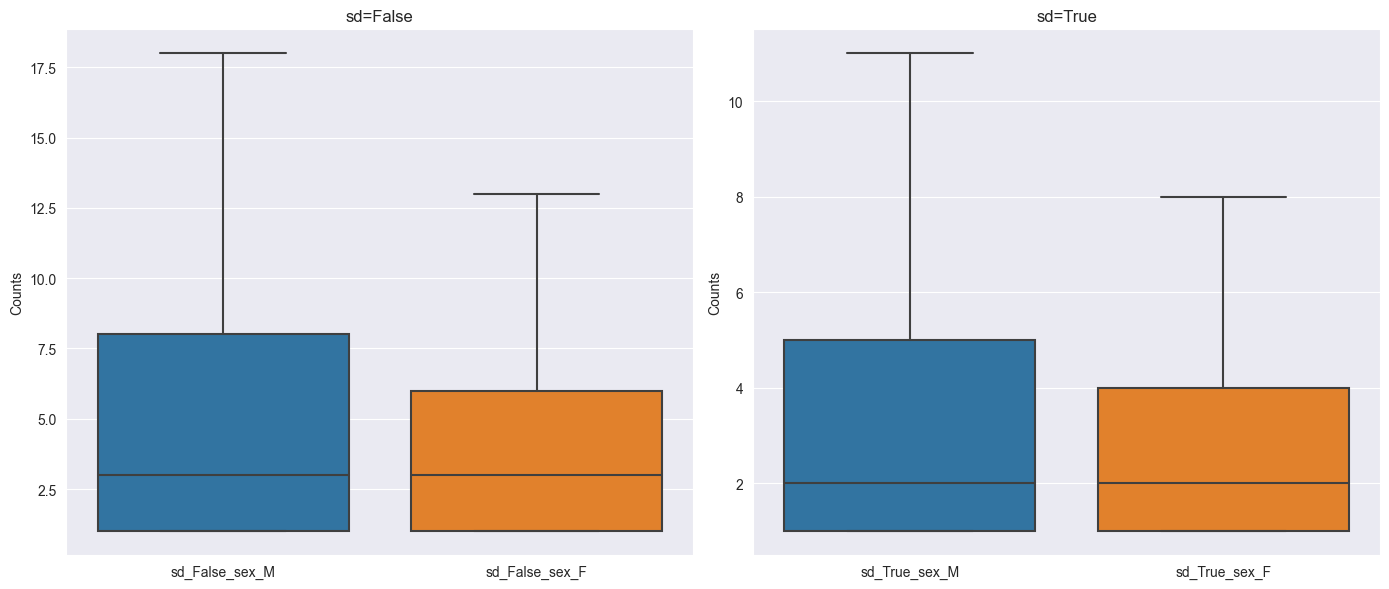

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_grouped_boxplots(grouped_dict, filename=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Plot for sd=False
    sns.boxplot(data=[grouped_dict[key]['counts'] for key in grouped_dict if 'sd_False' in key], 
                ax=axes[0], showfliers=False)
    axes[0].set_xticklabels([key for key in grouped_dict if 'sd_False' in key])
    axes[0].set_title("sd=False")
    axes[0].set_ylabel("Counts")
    
    # Plot for sd=True
    sns.boxplot(data=[grouped_dict[key]['counts'] for key in grouped_dict if 'sd_True' in key], 
                ax=axes[1], showfliers=False)
    axes[1].set_xticklabels([key for key in grouped_dict if 'sd_True' in key])
    axes[1].set_title("sd=True")
    axes[1].set_ylabel("Counts")

    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    else:
        plt.show()

# Usage:
plot_grouped_boxplots(grouped_dict, filename="bout_box_plot.pdf")




In [184]:
grouped_dict['sd_False_sex_F']


# get median value for counts



,name,bouts,counts
38,Fly05202022_5d,0,1
39,Fly05202022_5d,1,2
40,Fly05202022_5d,2,1
41,Fly05202022_5d,3,2
42,Fly05202022_5d,4,8
...,...,...,...
1850,Fly08012022_6d_B,45,1
1851,Fly08012022_6d_B,46,1
1852,Fly08012022_6d_B,47,4
1853,Fly08012022_6d_B,48,7


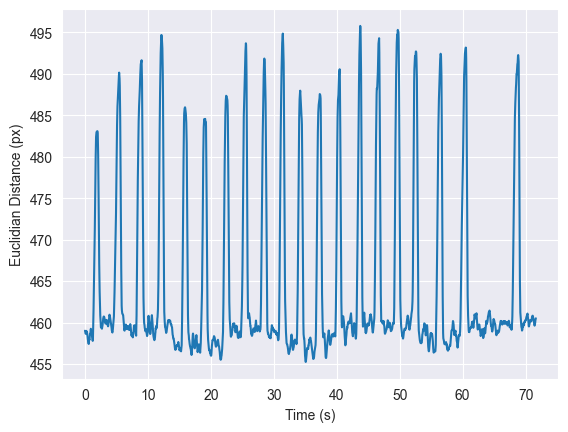

In [49]:
rep_trace_path = r'Z:\mfk\basty-projects\bouts_to_csv\Fly06272022_5d_A.csv'
rep_trace = pd.read_csv(rep_trace_path)
# Define your start, stop, and step values for the ticks
start = 1000
stop = 3150
step = 10*30

# Generate the tick positions and labels
tick_positions = np.arange(start, stop, step)
tick_labels = np.arange(0, len(tick_positions)*10, 10)

# Plot the data
plt.plot(rep_trace['49'][start:stop])
plt.ylabel('Euclidian Distance (px)')
plt.xlabel('Time (s)')
# Set the x-axis ticks and labels
plt.xticks(tick_positions, tick_labels)
plt.savefig('example_trace_pumps_trial_49_fly06272022_5d_A.pdf', dpi=300, bbox_inches='tight')
plt.show()


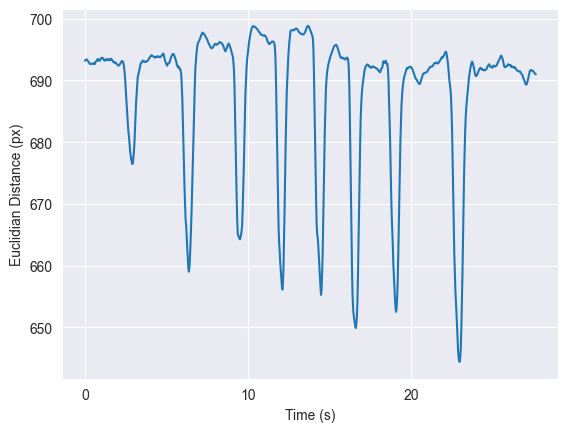

In [51]:
rep_trace_path = r'Z:\mfk\basty-projects\bouts_to_csv\Fly06072022_5d.csv'
rep_trace = pd.read_csv(rep_trace_path)
# Define your start, stop, and step values for the ticks
start = 360
stop = 1190
step = 10*30

# Generate the tick positions and labels
tick_positions = np.arange(start, stop, step)
tick_labels = np.arange(0, len(tick_positions)*10, 10)

# Plot the data
plt.plot(rep_trace['27'][start:stop])
plt.ylabel('Euclidian Distance (px)')
plt.xlabel('Time (s)')
# Set the x-axis ticks and labels
plt.xticks(tick_positions, tick_labels)
plt.savefig('example_trace_pumps_trial_27_fFly06072022_5d.pdf', dpi=300, bbox_inches='tight')
plt.show()

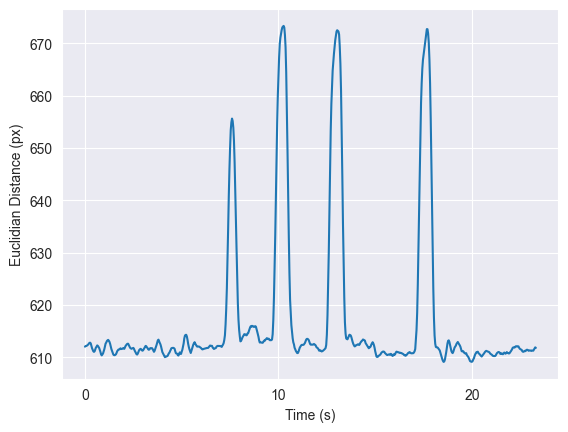

In [133]:
fly_name = 'Fly08012022_6d_B'
rep_trace_path = rf'Z:\mfk\basty-projects\bouts_to_csv\{fly_name}.csv'
rep_trace = pd.read_csv(rep_trace_path)
# Define your start, stop, and step values for the ticks
start = 300
stop = 1000
step = 10*30

# Generate the tick positions and labels
tick_positions = np.arange(start, stop, step)
tick_labels = np.arange(0, len(tick_positions)*10, 10)

t_id = '16'

# Plot the data
plt.plot(rep_trace['16'][start:stop])
plt.ylabel('Euclidian Distance (px)')
plt.xlabel('Time (s)')
# Set the x-axis ticks and labels
plt.xticks(tick_positions, tick_labels)
plt.savefig(f'example_trace_pumps_trial_{t_id}_{fly_name}.pdf', dpi=300, bbox_inches='tight')
plt.show()

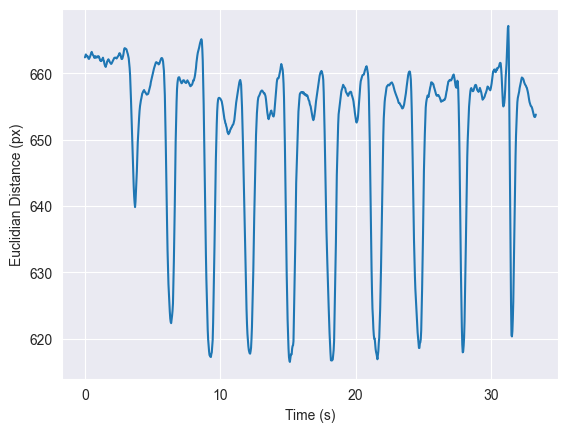

In [135]:
fly_name = 'Fly08012022_6d_B'
rep_trace_path = rf'Z:\mfk\basty-projects\bouts_to_csv\{fly_name}.csv'
rep_trace = pd.read_csv(rep_trace_path)
# Define your start, stop, and step values for the ticks
start = 450 
stop = 1450
step = 10*30

# Generate the tick positions and labels
tick_positions = np.arange(start, stop, step)
tick_labels = np.arange(0, len(tick_positions)*10, 10)

t_id = '39'

# Plot the data
plt.plot(rep_trace[t_id][start:stop])
plt.ylabel('Euclidian Distance (px)')
plt.xlabel('Time (s)')
# Set the x-axis ticks and labels
plt.xticks(tick_positions, tick_labels)
plt.savefig(f'example_trace_pumps_trial_{t_id}_{fly_name}.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Calculate the count of elements in a bout for each unique name and bout
sorted_df['bout_count'] = sorted_df.groupby(['name', 'bouts'])['peak_index'].transform('count')

# Calculate the pump_pos corresponding to the first element (minimum) for a bout
sorted_df['min_pump_pos'] = sorted_df.groupby(['name', 'bouts'])['pump_pos'].transform('min')

sorted_df.sort_values(by=['counts'],ascending=False)

In [ ]:
distinct_df = sorted_df[['name', 'bout_count','min_pump_pos']].drop_duplicates().reset_index(drop=True)

In [ ]:
sns.scatterplot(x='min_pump_pos', y='bout_count', data=sub_distinct)
plt.title('Scatterplot of bout_count vs. min_pump_pos')
plt.show()

In [169]:
sub_distinct =  distinct_df[(distinct_df['name'].map(name_to_sd) == True) ]

In [ ]:
unique_names = sub_distinct['name'].unique()

for name in unique_names:
    subset = sub_distinct[sub_distinct['name'] == name]
    sns.scatterplot(x='min_pump_pos', y='bout_count', data=subset)
    plt.title(f'Scatterplot for {name}')
    plt.show()

C:\Users\Grover\anaconda3\envs\flysleepcl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


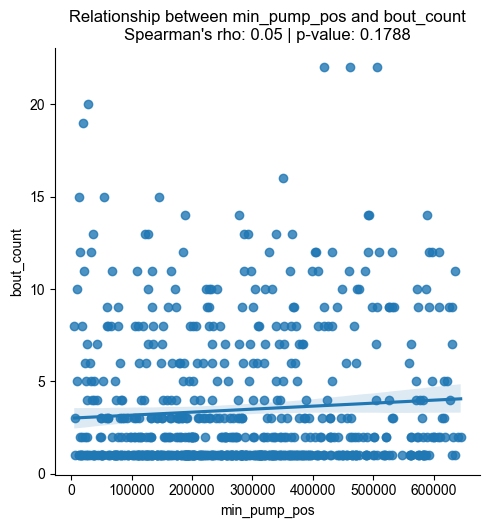

In [172]:
from scipy.stats import spearmanr
sns.lmplot(x='min_pump_pos',y='bout_count',data = sub_distinct)
rho, p = spearmanr(sub_distinct['min_pump_pos'], sub_distinct['bout_count'])
plt.title(f"Relationship between min_pump_pos and bout_count\nSpearman's rho: {rho:.2f} | p-value: {p:.4f}")
plt.show()

In [15]:
print(sorted_df.head())

    peak_index        value  trial_id            name  start  pump_pos  bouts  \
0          534  1014.361120         0  Fly05182022_5d   2349      2883      0   
1          694  1017.733769         0  Fly05182022_5d   2349      3043      0   
2          903  1027.228163         0  Fly05182022_5d   2349      3252      0   
3         1207  1021.721591         0  Fly05182022_5d   2349      3556      0   
84        1439   916.637105         0  Fly05182022_5d   2349      3788      0   

    bout_count  min_pump_pos  
0            6          2883  
1            6          2883  
2            6          2883  
3            6          2883  
84           6          2883  


In [148]:
threshold = 3

# Filtering based on bout_count
filtered_df = sorted_df[sorted_df['bout_count'] >= threshold]

# Calculate differences between consecutive peak_index values for each group
filtered_df['peak_diff'] = filtered_df.groupby(['name', 'bouts'])['pump_pos'].diff().fillna(0)


C:\Users\Grover\AppData\Local\Temp\ipykernel_48516\2093103244.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['peak_diff'] = filtered_df.groupby(['name', 'bouts'])['pump_pos'].diff().fillna(0)


In [149]:
filtered_df = filtered_df[filtered_df['peak_diff'] != 0]

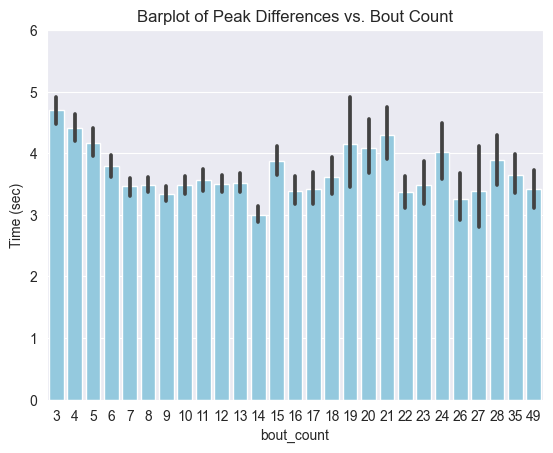

In [61]:
sns.barplot(x='bout_count', y='peak_diff', data=filtered_df,color='skyblue')
plt.ylabel('Time (sec)')
plt.title('Barplot of Peak Differences vs. Bout Count')
max_value = 6*30
yticks = np.arange(0, max_value + 30, 30)  # Here we add 30 just to make sure the last tick is included
yticklabels = [str(int(y/30)) for y in yticks]
plt.yticks(yticks, yticklabels)
plt.savefig('Barplot_peak_diff_vs_bout_count.pdf', bbox_inches='tight')

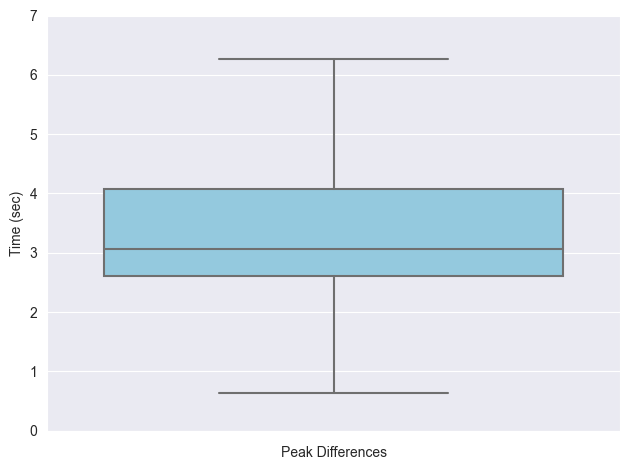

In [147]:
ax = sns.boxplot(y=filtered_df['peak_diff'], showfliers=False, color="skyblue")
max_value = 210
yticks = np.arange(0, max_value + 30, 30)  # Here we add 30 just to make sure the last tick is included
yticklabels = [str(int(y/30)) for y in yticks]
plt.yticks(yticks, yticklabels)
plt.ylabel('Time (sec)')
plt.xlabel('Peak Differences')
# Annotate the boxplot with mean and median
mean_val = filtered_df['peak_diff'].mean()
median_val = filtered_df['peak_diff'].median()

ax.annotate('Mean: {:.2f}'.format(mean_val), xy=(0.7, mean_val), xytext=(0.8, mean_val+10),
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            horizontalalignment='right', verticalalignment='top')
ax.annotate('Median: {:.2f}'.format(median_val), xy=(0.7, median_val), xytext=(0.8, median_val-20),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='right', verticalalignment='bottom')
plt.tight_layout()  # Ensure all elements fit in the saved figure
plt.savefig('Boxplot_peak_diff.pdf', bbox_inches='tight')

plt.show()

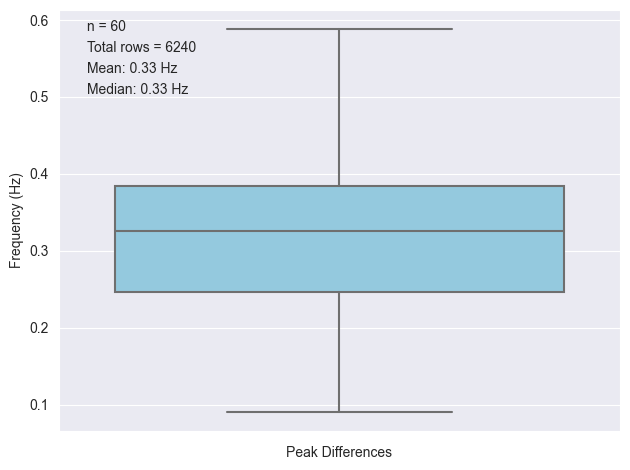

In [153]:
filtered_df['sd'] = filtered_df['name'].map(name_to_sd)

# Convert 'peak_diff' values to frequencies
filtered_df['frequency'] = 30 / filtered_df['peak_diff']

ax = sns.boxplot(y=filtered_df['frequency'], showfliers=False, color="skyblue")

plt.ylabel('Frequency (Hz)')
plt.xlabel('Peak Differences')

# Calculate unique 'name' count
unique_name_count = filtered_df['name'].nunique()

# Annotate the boxplot with mean and median of frequencies
mean_freq = filtered_df['frequency'].mean()
median_freq = filtered_df['frequency'].median()
total_rows_plotted = len(filtered_df)

# Annotate the unique count, mean, and median
# Annotate the unique count, total rows, mean, and median
ax.annotate('n = {}'.format(unique_name_count), xy=(0.05, 0.95), xycoords='axes fraction')
ax.annotate('Total rows = {}'.format(total_rows_plotted), xy=(0.05, 0.90), xycoords='axes fraction')
ax.annotate('Mean: {:.2f} Hz'.format(mean_freq), xy=(0.05, 0.85), xycoords='axes fraction')
ax.annotate('Median: {:.2f} Hz'.format(median_freq), xy=(0.05, 0.80), xycoords='axes fraction')


plt.tight_layout()  # Ensure all elements fit in the saved figure

plt.savefig('Boxplot_peak_diff_freq.pdf', bbox_inches='tight')
plt.show()

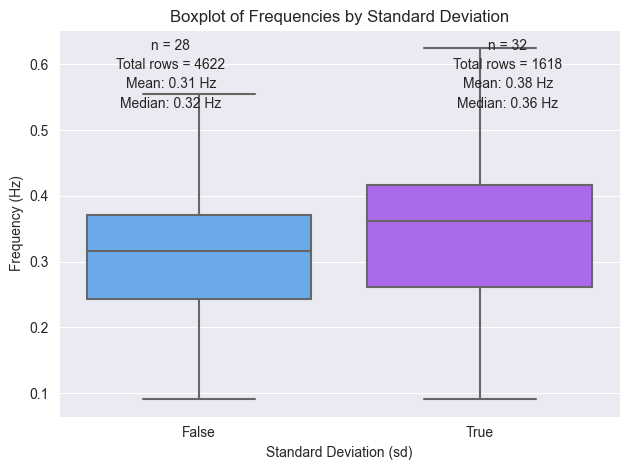

In [173]:
# Split the data based on the 'sd' value
# Split the data based on the 'sd' value
sd_true = filtered_df[filtered_df['sd'] == True]
sd_false = filtered_df[filtered_df['sd'] == False]

# Create the boxplot
ax = sns.boxplot(x='sd', y='frequency', data=filtered_df, showfliers=False, palette="cool")

plt.ylabel('Frequency (Hz)')
plt.xlabel('Standard Deviation (sd)')
plt.title('Boxplot of Frequencies by Standard Deviation')

# Annotate the unique count, total rows, mean, and median of frequencies for both sd=True and sd=False
for index, sd_val in enumerate([True, False]):
    subset = filtered_df[filtered_df['sd'] == sd_val]
    
    unique_name_count = subset['name'].nunique()
    total_rows_plotted = len(subset)
    mean_freq = subset['frequency'].mean()
    median_freq = subset['frequency'].median()

    # Adjusting x-coordinate for placing annotations based on sd value
    x_coord = 0.8 if sd_val else 0.2

    ax.annotate('n = {}'.format(unique_name_count), xy=(x_coord, 0.95), xycoords='axes fraction', horizontalalignment='center')
    ax.annotate('Total rows = {}'.format(total_rows_plotted), xy=(x_coord, 0.90), xycoords='axes fraction', horizontalalignment='center')
    ax.annotate('Mean: {:.2f} Hz'.format(mean_freq), xy=(x_coord, 0.85), xycoords='axes fraction', horizontalalignment='center')
    ax.annotate('Median: {:.2f} Hz'.format(median_freq), xy=(x_coord, 0.80), xycoords='axes fraction', horizontalalignment='center')

plt.tight_layout()  # Ensure all elements fit in the saved figure
plt.savefig('Boxplot_peak_diff_freq_by_sd.pdf', bbox_inches='tight')
plt.show()


In [174]:
# Run a mann-whitney u test on the frequency column between the sd_true and sd_false for frequency
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(sd_true['frequency'], sd_false['frequency'])
print('Statistics=%.3f, p=%.3f' % (stat, p))


Statistics=4494707.500, p=0.000


Statistics=702.000, p=0.000


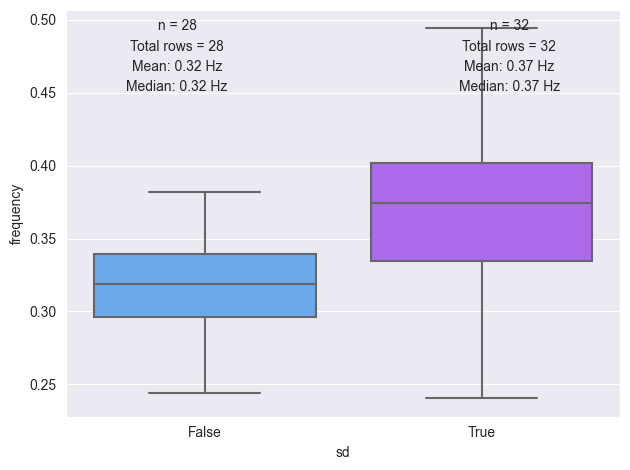

In [172]:
# Run a mann-whitney u test on the frequency column between the two groups

# first average the frequency for each unique name
averaged_df = filtered_df.groupby('name')['frequency'].mean().reset_index()

# Check if name has "sd" in it
def check_sd(name):
    return 'SD' in name

# Create a new column 'sd' to indicate whether the name has "sd" in it
averaged_df['sd'] = averaged_df['name'].apply(check_sd)

# Split the data based on the 'sd' value
sd_true = averaged_df[averaged_df['sd'] == True]
sd_false = averaged_df[averaged_df['sd'] == False]

# Run the mann-whitney u test
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(sd_true['frequency'], sd_false['frequency'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# boxplot of the frequency column
ax = sns.boxplot(x='sd', y='frequency', data=averaged_df, showfliers=False, palette="cool")

# Annotate the boxplot with mean and median of frequencies for both sd=True and sd=False
for index, sd_val in enumerate([True, False]):
    subset = averaged_df[averaged_df['sd'] == sd_val]
    
    unique_name_count = subset['name'].nunique()
    total_rows_plotted = len(subset)
    mean_freq = subset['frequency'].mean()
    median_freq = subset['frequency'].median()

    # Adjusting x-coordinate for placing annotations based on sd value
    x_coord = 0.8 if sd_val else 0.2

    ax.annotate('n = {}'.format(unique_name_count), xy=(x_coord, 0.95), xycoords='axes fraction', horizontalalignment='center')
    ax.annotate('Total rows = {}'.format(total_rows_plotted), xy=(x_coord, 0.90), xycoords='axes fraction', horizontalalignment='center')
    ax.annotate('Mean: {:.2f} Hz'.format(mean_freq), xy=(x_coord, 0.85), xycoords='axes fraction', horizontalalignment='center')
    ax.annotate('Median: {:.2f} Hz'.format(median_freq), xy=(x_coord, 0.80), xycoords='axes fraction', horizontalalignment='center')

#save the figure
plt.tight_layout()  # Ensure all elements fit in the saved figure
plt.savefig('Boxplot_average_peak_diff_freq_by_sd.pdf', bbox_inches='tight')
plt.show()

In [169]:
len(sd_true)

32

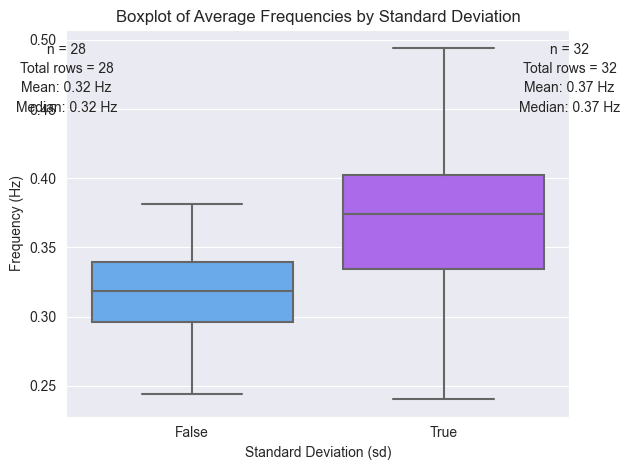

In [158]:

# Convert 'peak_diff' values to frequencies
filtered_df['frequency'] = 30 / filtered_df['peak_diff']

# Compute average frequency for each unique 'name'
averaged_df = filtered_df.groupby(['name', 'sd'])['frequency'].mean().reset_index()

# Create the boxplot
ax = sns.boxplot(x='sd', y='frequency', data=averaged_df, showfliers=False, palette="cool")

plt.ylabel('Frequency (Hz)')
plt.xlabel('Standard Deviation (sd)')
plt.title('Boxplot of Average Frequencies by Standard Deviation')

# Annotate the boxplot with mean and median of averaged frequencies for both sd=True and sd=False
for sd_val in [True, False]:
    subset = averaged_df[averaged_df['sd'] == sd_val]
    mean_freq = subset['frequency'].mean()
    median_freq = subset['frequency'].median()
    unique_name_count = subset['name'].nunique()
    total_rows = len(subset)

    # Adjust the x-coordinate in the annotation based on the sd value
    x_coord = 1 if sd_val else 0

    ax.text(x_coord, 0.95, 'n = {}'.format(unique_name_count), ha='center', va='center', transform=ax.transAxes)
    ax.text(x_coord, 0.9, 'Total rows = {}'.format(total_rows), ha='center', va='center', transform=ax.transAxes)
    ax.text(x_coord, 0.85, 'Mean: {:.2f} Hz'.format(mean_freq), ha='center', va='center', transform=ax.transAxes)
    ax.text(x_coord, 0.8, 'Median: {:.2f} Hz'.format(median_freq), ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()  # Ensure all elements fit in the saved figure
plt.savefig('Boxplot_average_peak_diff_freq_by_sd_per_ind.pdf', bbox_inches='tight')
plt.show()

In [71]:
import pandas as pd

def extract_first_last_peak_diff(bout_count, dataframe):
    # Filter the dataframe based on the provided bout count
    filtered_df = dataframe[dataframe['bout_count'] == bout_count]

    # Group by 'name' and 'bouts', then aggregate using the first and last of 'peak_diff'
    aggregated_df = filtered_df.groupby(['name', 'bouts']).agg(
        first_peak_diff=('peak_diff', 'first'),
        last_peak_diff=('peak_diff', 'last')
    ).reset_index()

    # Return the final dataframe with the desired columns
    return aggregated_df[['first_peak_diff', 'last_peak_diff', 'bouts']]

# Example usage:
bout_count = 6
result = extract_first_last_peak_diff(bout_count, filtered_df)
print(result)



    first_peak_diff  last_peak_diff  bouts
0             160.0           184.0      0
1             131.0           295.0      3
2             106.0           220.0      8
3             111.0            65.0     32
4              88.0           162.0     12
..              ...             ...    ...
82             74.0            96.0      6
83             87.0           106.0     17
84            133.0           324.0     27
85             78.0            83.0      2
86             82.0           138.0     15

[87 rows x 3 columns]


In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ... [previous code and extract_first_last_peak_diff function] ...

plt.figure(figsize=(10, 6))

# Filtering and sorting data
filtered_data = filtered_df[(filtered_df['bout_count'] >= 5) & (filtered_df['bout_count'] <= 10)]

first_peak_diffs = []
last_peak_diffs = []
for _, group in filtered_data.groupby(['name', 'bouts']):
    if group['bout_count'].iloc[0] in range(5, 11):  
        first_peak_diffs.append(group['peak_diff'].iloc[0])
        last_peak_diffs.append(group['peak_diff'].iloc[-1])


plt.figure(figsize=(10, 6))

# Overlaying the strip plots with some transparency
sns.stripplot(x=[0]*len(first_peak_diffs), y=first_peak_diffs, color='blue', size=5, alpha=0.5, jitter=True)
sns.stripplot(x=[1]*len(last_peak_diffs), y=last_peak_diffs, color='red', size=5, alpha=0.5, jitter=True)

# Overlay a pointplot
sns.pointplot(data=[first_peak_diffs, last_peak_diffs], join=False, palette='pastel', markers=["o", "x"], capsize=0.2, scale=1.5)

plt.xticks([0, 1], ['First peak_diff', 'Last peak_diff'])
plt.ylabel('Time (sec)')
plt.title('Paired Observations & Point Plot of First and Last Peak Differences for Bout Counts 5-10')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



KeyError: 'sd'

<Figure size 1000x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

C:\Users\Grover\AppData\Local\Temp\ipykernel_48516\3665265291.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['sd'] = filtered_data['name'].map(name_to_sd)


Paired t-test for SD=False: t-statistic = -6.288872262852039, p-value = 1.1735812818006893e-06
Paired t-test for SD=True: t-statistic = -3.5291521738380967, p-value = 0.0014118700371087325


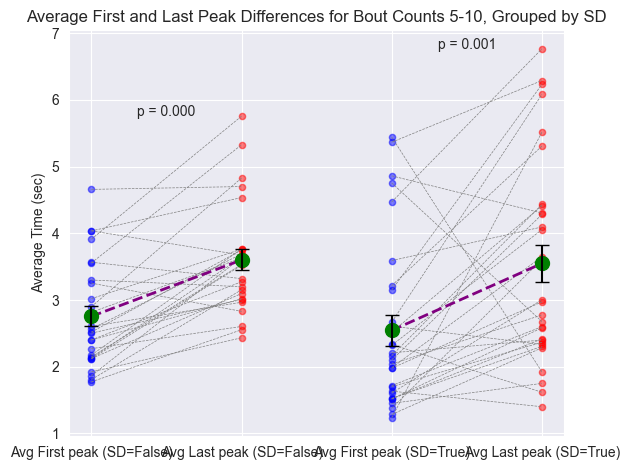

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import seaborn as sns

# Assume filtered_df and expt_info_df are defined
# ...

# Map 'name' to 'sd'
name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))

# Filter and sort data
filtered_data = filtered_df[(filtered_df['bout_count'] >= 5) & (filtered_df['bout_count'] <= 10)]

# Add 'sd' column to filtered_data
filtered_data['sd'] = filtered_data['name'].map(name_to_sd)
# Initialize an empty list to store average data points for pointplot
mean_sem_data = {'SD=False': {}, 'SD=True': {}}


# Iterate over each SD value (True or False)
for idx, sd_val in enumerate([False, True]):
    sd_key = f'SD={sd_val}'
    # Filter data based on current SD value
    sd_filtered_data = filtered_data[filtered_data['sd'] == sd_val]
    
    # Initialize lists for paired t-test and for calculating mean and SEM
    paired_first_peaks = []
    paired_last_peaks = []
    
    # Group by 'name' and then by 'bouts' to compute the average first and last 'peak_diff'
    for name, name_group in sd_filtered_data.groupby('name'):
        first_peaks = []
        last_peaks = []
        for _, bout_group in name_group.groupby('bouts'):
            if bout_group['bout_count'].iloc[0] in range(5, 11):
                first_peaks.append(bout_group['peak_diff'].iloc[0])
                last_peaks.append(bout_group['peak_diff'].iloc[-1])
        
        # Compute average for each name
        if first_peaks and last_peaks:
            avg_first = np.mean(first_peaks)
            avg_last = np.mean(last_peaks)
            
            # Store for paired t-test
            paired_first_peaks.append(avg_first)
            paired_last_peaks.append(avg_last)
            
            # Scatterplot
            plt.scatter([idx*2]*len([avg_first]), [avg_first], color='blue', s=20, alpha=0.5)
            plt.scatter([idx*2 + 1]*len([avg_last]), [avg_last], color='red', s=20, alpha=0.5)
            
            # Draw individual connecting lines
            plt.plot([idx*2, idx*2 + 1], [avg_first, avg_last], linestyle='--', color='grey', linewidth=0.5)
    # Calculate mean and SEM for first and last peaks
    mean_first = np.mean(paired_first_peaks)
    mean_last = np.mean(paired_last_peaks)
    sem_first = np.std(paired_first_peaks, ddof=1) / np.sqrt(len(paired_first_peaks))
    sem_last = np.std(paired_last_peaks, ddof=1) / np.sqrt(len(paired_last_peaks))
    
    # Store mean and SEM for later use
    mean_sem_data[sd_key] = {'mean_first': mean_first, 'mean_last': mean_last, 'sem_first': sem_first, 'sem_last': sem_last}
    
    # Draw mean dots
    plt.scatter([idx*2], [mean_first], color='green', s=100, zorder=5)
    plt.scatter([idx*2 + 1], [mean_last], color='green', s=100, zorder=5)
    
    # Draw error bars
    plt.errorbar([idx*2], [mean_first], yerr=[sem_first], color='black', capsize=5, zorder=6)
    plt.errorbar([idx*2 + 1], [mean_last], yerr=[sem_last], color='black', capsize=5, zorder=6)

    # Perform paired t-test
    t_stat, p_val = ttest_rel(paired_first_peaks, paired_last_peaks)
    print(f"Paired t-test for {sd_key}: t-statistic = {t_stat}, p-value = {p_val}")
    
    # Annotate with p-value
    plt.annotate(f'p = {p_val:.3f}', xy=(idx*2 + 0.5, max(paired_first_peaks + paired_last_peaks)), ha='center')



# Draw connecting lines for mean dots
for idx, (sd_key, data) in enumerate(mean_sem_data.items()):
    plt.plot([idx*2, idx*2 + 1], [data['mean_first'], data['mean_last']], color='purple', linestyle='--', linewidth=2)


max_value = 225
yticks = np.arange(50, max_value + 30, 30)  # Here we add 30 just to make sure the last tick is included
yticklabels = [str(int(y/30)) for y in yticks]
plt.yticks(yticks, yticklabels)
# Adjust x-ticks and labels
plt.xticks([0, 1, 2, 3], ['Avg First peak (SD=False)', 'Avg Last peak (SD=False)', 'Avg First peak (SD=True)', 'Avg Last peak (SD=True)'])
plt.ylabel('Average Time (sec)')
plt.title('Average First and Last Peak Differences for Bout Counts 5-10, Grouped by SD')
plt.savefig('Avg_First_Last_peak_diffs.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [88]:
filtered_df

,peak_index,value,trial_id,name,start,pump_pos,bouts,bout_count,min_pump_pos,peak_diff
1,694,1017.733769,0,Fly05182022_5d,2349,3043,0,6,2883,160.0
2,903,1027.228163,0,Fly05182022_5d,2349,3252,0,6,2883,209.0
3,1207,1021.721591,0,Fly05182022_5d,2349,3556,0,6,2883,304.0
84,1439,916.637105,0,Fly05182022_5d,2349,3788,0,6,2883,232.0
4,1623,1023.545935,0,Fly05182022_5d,2349,3972,0,6,2883,184.0
...,...,...,...,...,...,...,...,...,...,...
8486,835,387.119720,22,Fly08032022_6d_SD_B,625280,626115,31,9,625816,68.0
8487,905,386.726096,22,Fly08032022_6d_SD_B,625280,626185,31,9,625816,70.0
8488,966,389.234434,22,Fly08032022_6d_SD_B,625280,626246,31,9,625816,61.0
8489,1041,504.997931,22,Fly08032022_6d_SD_B,625280,626321,31,9,625816,75.0


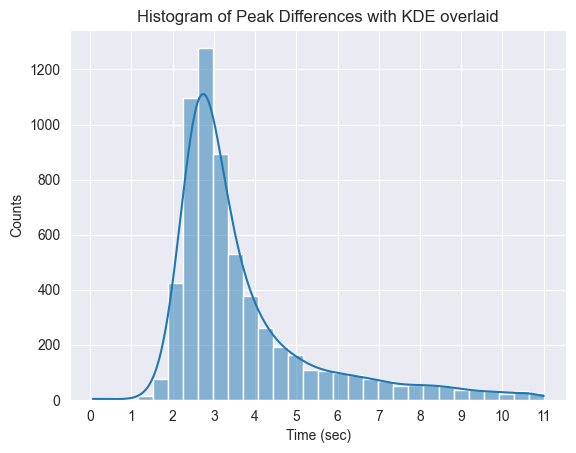

Plot saved as Histogram_with_KDE_all_6240_datapoints.pdf


In [25]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Create a histogram with KDE overlaid
sns.histplot(data=filtered_df, x='peak_diff', kde=True, bins=30)

plt.xlabel('Time (sec)')
plt.ylabel('Frequency')
plt.title('Histogram of Peak Differences with KDE overlaid')



# Adjusting x-ticks to 1-second increments (30 data points = 1 second)
max_value = filtered_df['peak_diff'].max()
xticks = np.arange(0, max_value + 30, 30)
xticklabels = [str(int(x/30)) for x in xticks]
plt.ylabel('Counts')
plt.xticks(xticks, xticklabels)

# Save the plot
num_datapoints = len(filtered_df['peak_diff'])
filename = f'Histogram_with_KDE_all_{num_datapoints}_datapoints.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.show()

print(f"Plot saved as {filename}")


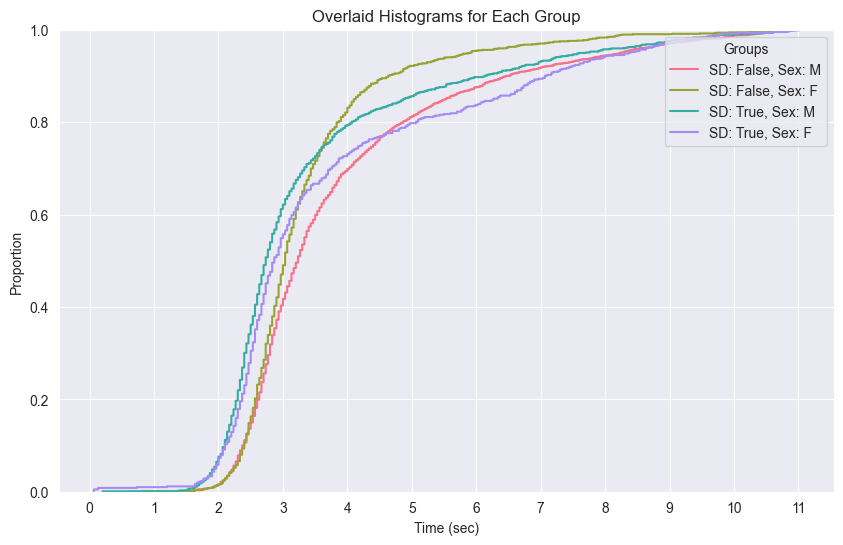

In [74]:
# Create Histograms for all of groups
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define groups
# Possible values for sd and sex
sd_values = [False, True]
sex_values = ['M', 'F']
name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))

# Define a color palette
palette = sns.color_palette("husl", len(sd_values) * len(sex_values))

# Begin plotting
plt.figure(figsize=(10, 6))

# Counter for palette
count = 0

for sd in sd_values:
    for sex in sex_values:
        # Create a mask for current group
        subset_data = filtered_df[(filtered_df['name'].map(name_to_sd) == sd) & (filtered_df['name'].map(name_to_sex) == sex)]
        
        # Subset data
        subset_data = subset_data['peak_diff']
        
        # Create label for current group
        sd_str = 'True' if sd else 'False'
        label = f'SD: {sd_str}, Sex: {sex}'
        
        # Plot the histogram for the subset
        sns.ecdfplot(subset_data,label=label, color=palette[count])
        
        count += 1

# Finalizing the plot
plt.title('Overlaid Histograms for Each Group')
plt.xlabel('Time (sec)')
plt.ylabel('Proportion')
plt.legend(title='Groups', loc='upper right')
max_value = filtered_df['peak_diff'].max()
xticks = np.arange(0, max_value + 30, 30)
xticklabels = [str(int(x/30)) for x in xticks]
plt.xticks(xticks, xticklabels)
filename = f'ECDF_grouped_datapoints.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.show()




In [40]:
filtered_df

,peak_index,value,trial_id,name,start,pump_pos,bouts,bout_count,min_pump_pos,peak_diff
1,694,1017.733769,0,Fly05182022_5d,2349,3043,0,6,2883,160.0
2,903,1027.228163,0,Fly05182022_5d,2349,3252,0,6,2883,209.0
3,1207,1021.721591,0,Fly05182022_5d,2349,3556,0,6,2883,304.0
84,1439,916.637105,0,Fly05182022_5d,2349,3788,0,6,2883,232.0
4,1623,1023.545935,0,Fly05182022_5d,2349,3972,0,6,2883,184.0
...,...,...,...,...,...,...,...,...,...,...
8486,835,387.119720,22,Fly08032022_6d_SD_B,625280,626115,31,9,625816,68.0
8487,905,386.726096,22,Fly08032022_6d_SD_B,625280,626185,31,9,625816,70.0
8488,966,389.234434,22,Fly08032022_6d_SD_B,625280,626246,31,9,625816,61.0
8489,1041,504.997931,22,Fly08032022_6d_SD_B,625280,626321,31,9,625816,75.0


In [37]:
from sklearn.mixture import GaussianMixture
import numpy as np

data = filtered_df['peak_diff'].values.reshape(-1, 1)
lowest_bic = np.infty
best_n = None
best_gmm = None

n_components_range = [2,3,4,5]
for n in n_components_range:
    gmm = GaussianMixture(n_components=n)
    gmm.fit(data)
    bic = gmm.bic(data)
    if bic < lowest_bic:
        lowest_bic = bic
        best_n = n
        best_gmm = gmm

labels = best_gmm.predict(data)


In [38]:
best_n

3

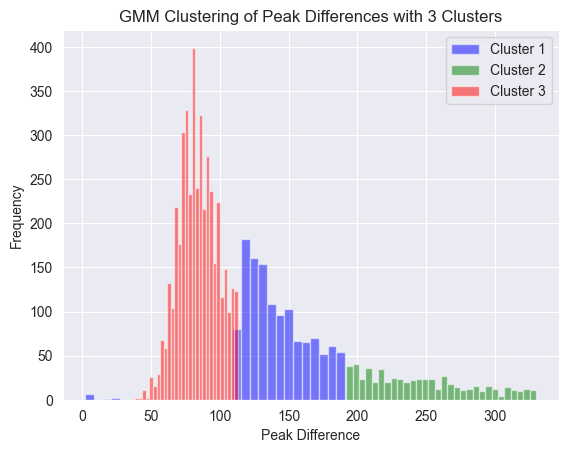

In [39]:
import matplotlib.pyplot as plt

# Histogram Visualization for the GMM Clustering
unique_labels = np.unique(labels)
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Colors for each cluster

for i, label in enumerate(unique_labels):
    plt.hist(data[labels == label], bins=30, alpha=0.5, color=colors[i], label=f'Cluster {label + 1}')

plt.legend()
plt.title(f'GMM Clustering of Peak Differences with {best_n} Clusters')
plt.xlabel('Peak Difference')
plt.ylabel('Frequency')
plt.show()



In [199]:
filtered_df

,peak_index,value,trial_id,name,start,pump_pos,bouts,bout_count,min_pump_pos,peak_diff
1,694,1017.733769,0,Fly05182022_5d,2349,3043,0,6,2883,160.0
2,903,1027.228163,0,Fly05182022_5d,2349,3252,0,6,2883,209.0
3,1207,1021.721591,0,Fly05182022_5d,2349,3556,0,6,2883,304.0
84,1439,916.637105,0,Fly05182022_5d,2349,3788,0,6,2883,232.0
4,1623,1023.545935,0,Fly05182022_5d,2349,3972,0,6,2883,184.0
...,...,...,...,...,...,...,...,...,...,...
8486,835,387.119720,22,Fly08032022_6d_SD_B,625280,626115,31,9,625816,68.0
8487,905,386.726096,22,Fly08032022_6d_SD_B,625280,626185,31,9,625816,70.0
8488,966,389.234434,22,Fly08032022_6d_SD_B,625280,626246,31,9,625816,61.0
8489,1041,504.997931,22,Fly08032022_6d_SD_B,625280,626321,31,9,625816,75.0


In [109]:
subsub_df = filtered_df[filtered_df['name'] == 'Fly06272022_5d_A']

In [114]:
seconds = subsub_df[subsub_df['bouts'] == 78]['peak_diff']/30

In [117]:
freqs = 1/seconds

In [118]:
freqs

3206         inf
3207    0.476190
3208    0.476190
3209    0.361446
3210    0.384615
3212    0.389610
3211    0.454545
3213    0.315789
3214    0.422535
3216    0.400000
3215    0.468750
3217    0.468750
3218    0.303030
3219    0.326087
3220    0.416667
3221    0.209790
3222    0.209790
3223    0.193548
3224    0.163934
3225    0.220588
3226    0.146341
3227    0.167598
3228    0.218978
3229    0.196078
3230    0.285714
3231    0.344828
3232    0.270270
3233    0.303030
3234    0.280374
3235    0.405405
3236    0.294118
3237    0.357143
3238    0.422535
3239    0.312500
3240    0.275229
3241    0.422535
3242    0.384615
3243    0.361446
3244    0.291262
3245    0.340909
3246    0.297030
3247    0.250000
3248    0.394737
3249    0.352941
3250    0.384615
3251    0.215827
3252    0.280374
3253    0.218978
3254    0.258621
Name: peak_diff, dtype: float64

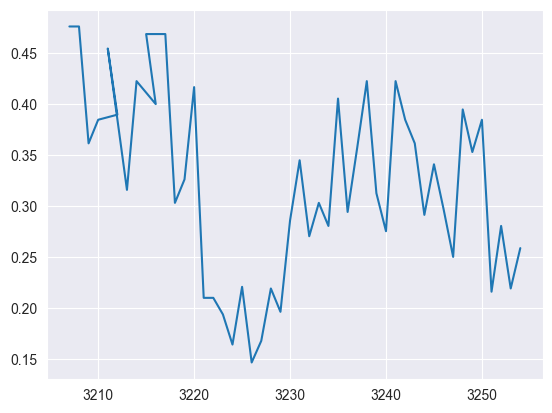

In [119]:
plt.plot(freqs)

In [121]:

# Decide on a window size for the rolling frequency (e.g., 3)
window_size = 3

# Compute rolling frequencies
rolling_frequencies = np.convolve(freqs, np.ones(window_size)/window_size, mode='valid')

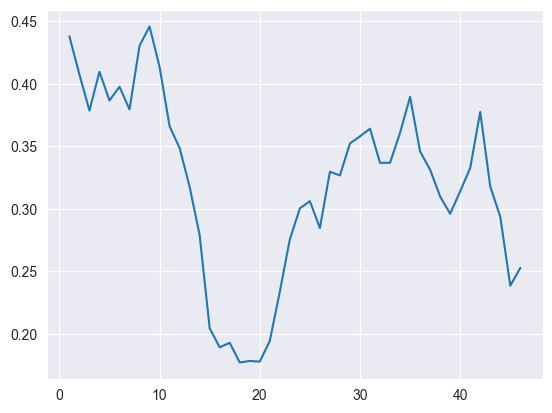

In [125]:
plt.plot(rolling_frequencies)
plt.savefig('rolling_frequencies.pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>